# Support & Resistance Study

The idea of "support" and the "resistance" in stock prices is a popular method used in technical analysis for determining when to buy or sell a stock. When a stock price falls into an area where many traders are interested in purchasing shares, the price may have a higher chance of increasing. These areas are called support levels. The opposite is true for resistance levels. In this notebook, we devise an algorithmic way to identify support and resistance based solely on historical share prices. Then we use these levels to generate a trading signal (buy or sell). This will allow us perform backtests and judge the usefulness of support and resistance levels.

In [ ]:
from collections import deque

In [139]:
start = '2008-01-04'
end = '2009-10-01'
asset = get_pricing('SPY', fields='price', start_date=start, end_date=end)
dates = asset.index

## How do we determine support and resistance?

A simple way of determining these levels is to find "turning points" in the stock price and build a distribution of where these occur. Let s_n be a sequence of stock prices. We'll define support points as any s_n where s_n-1 > s_n < s_n+1. Resistance points are likewise any s_n where s_n-1 < s_n > s_n+1. Peaks and troughs. Below is the code to find these points:

In [140]:
def getBottoms(prices, n=1):
    q = deque()
    bottoms = deque()
    for idx, p in enumerate(prices):
        
        # loop through all previous bottoms and invalidate until 
        # we encounter first bottom that is lower than the current point
        for bottom_idx, tmp_bottom in enumerate(bottoms):
            if p < tmp_bottom[1]:
                bottoms[bottom_idx] = (tmp_bottom[0], tmp_bottom[1], False)
            else:
                break
        
        if len(q) == 0:
            q.append(p)
        elif len(q) < n:
            if p < q[-1]:
                q.append(p)
            else:
                q.clear()
                q.append(p)
        elif len(q) == n:
            if p < q[-1]:
                q.append(p)
                bottoms.appendleft((idx,p,True))
            else:
                q.clear()
                q.append(p)
        elif len(q) > n:
            if len(q) == 2*n:
                if p > q[-1]:
                    q.clear()
                    q.append(p)
                else:
                    if n == 1: 
                        q.popleft()
                        q.append(p)
                        #del bottoms[-1]
                        bottoms.popleft()
                        bottoms.appendleft((idx,p,True))
                    else:
                        for i in range(n+1):
                            q.popleft()
                        q.append(p)
                        #del bottoms[-1]
                        bottoms.popleft()
            else:
                if p > q[-1]:
                    q.append(p)
                else:
                    for i in range(n):
                        q.popleft()
                    q.append(p)
                    #del bottoms[-1]
                    bottoms.popleft()
    return bottoms

In [141]:
def getTops(prices, n=1):
    return getBottoms(np.negative(prices), n)

In [142]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def plotTurningPoints(price_series, n=0):
    ''' Returns Tops and Bottoms of the inputed price series as a tuple
    '''
    # quick and dirty way to get bottoms and tops without calculating 2nd derivative
    bottoms = getBottoms(price_series,n)
    tops = getTops(price_series,n)

    _, ax = plt.subplots(1, sharex=True)
    
    ax.plot(price_series)
    ticks = ax.get_xticks()
    ax.set_xticklabels([price_series.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
    ax.set_title('Share Price with Turning Points')
    ax.plot([b[0] for b in bottoms], price_series[[b[0] for b in bottoms]], 'gD')
    ax.plot([t[0] for t in tops], price_series[[t[0] for t in tops]], 'rD')

    return (bottoms, tops)

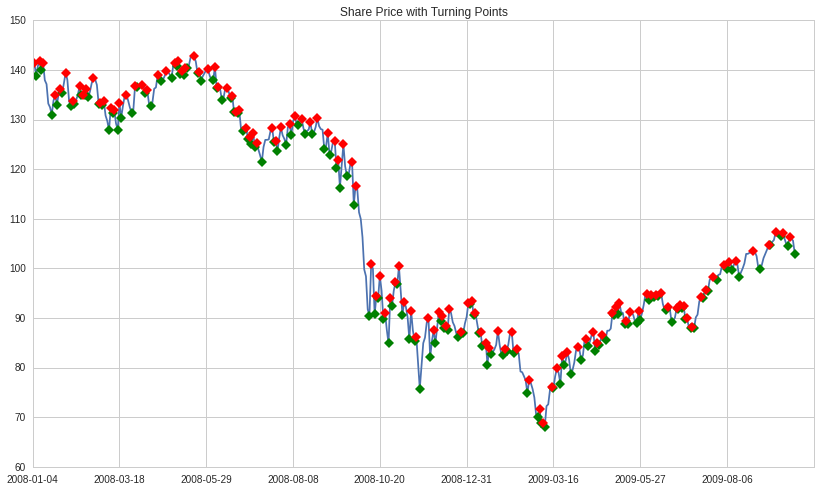

In [154]:
bottoms, tops = plotTurningPoints(asset, 1)

Before moving further, you'll notice in the code above that we kept track of a boolean variable for each turning point. This is used to determine whether or not the support or resistance point has been "broken". The idea is that once a level is pierced, that level is no longer an area of interest. In other words, the buyers and sellers who once bought or sold, respectively, have been exhausted and no longer show up to defend a certain price. Think an investor who is willing to purchase N shares at X price. Once N shares have been executed, there is no longer buying interest from that investor. The plot below illustrates this point buy highlighting the remainig valid support and resistance points.

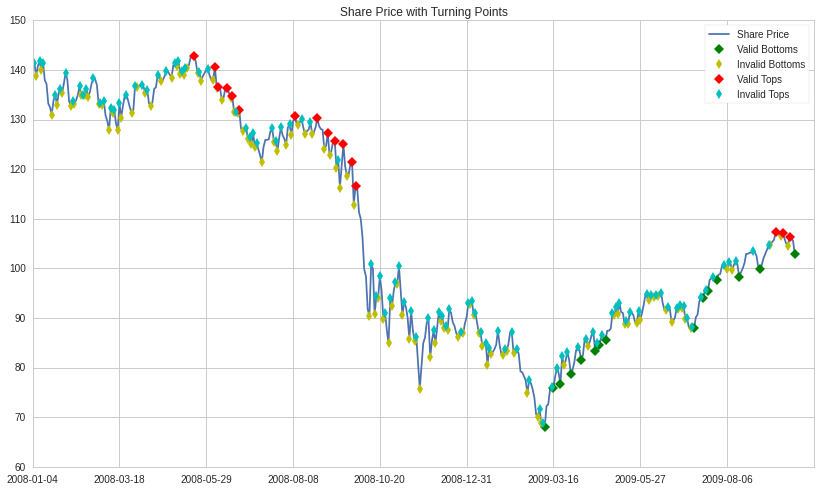

In [155]:
valid_bottoms = [b[0] for b in bottoms if b[2]]
invalid_bottoms = [b[0] for b in bottoms if not b[2]]

valid_tops = [b[0] for b in tops if b[2]]
invalid_tops = [b[0] for b in tops if not b[2]]

_, ax = plt.subplots(1, sharex=True)
ax.plot(asset)
ticks = ax.get_xticks()
ax.set_xticklabels([asset.index[i].date() for i in ticks[:-1]]) # Label x-axis with dates
ax.set_title('Share Price with Turning Points')
ax.plot(valid_bottoms, asset[valid_bottoms], 'gD')
ax.plot(invalid_bottoms, asset[invalid_bottoms], 'yd')
ax.plot(valid_tops, asset[valid_tops], 'rD')
ax.plot(invalid_tops, asset[invalid_tops], 'cd')
_ = ax.legend(['Share Price', 'Valid Bottoms', 'Invalid Bottoms', 'Valid Tops', 'Invalid Tops'])

## Generating a Signal

So we know we want to buy when there are lots of buyers and sell when there are lots of sellers. To determine where there are potentially a lot of traders waiting to act, we could build a histogram of the valid turning points which should show us what the important levels are. Even better than a histogram, we can generate a distribution of buying and selling interest using kernel density estimation.

In [148]:
from sklearn.neighbors import KernelDensity

In [152]:
def fit_KDE(X,num_bins=10):
    bins = np.linspace(X.min(),X.max(),num_bins)
    X_plot = np.linspace(X.min(), X.max(), 1000)[:,np.newaxis]
    fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
    #fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # histogram 1
    ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', normed=True)
    ax[0, 0].set_title("Histogram")

    # histogram 2
    ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', normed=True)
    ax[0, 1].set_title("Histogram, bins shifted")

    # tophat KDE
    kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    #ax[1,0].plot(X_plot, np.exp(log_dens))
    #ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax[1, 0].fill_between(X_plot[:,0], np.exp(log_dens), facecolor='#AAAAFF')
    ax[1, 0].set_title("Tophat Kernel Density")

    # Gaussian KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax[1, 1].fill_between(X_plot[:, 0], np.exp(log_dens), facecolor='#AAAAFF')
    ax[1, 1].set_title("Gaussian Kernel Density")
    return kde


For bottoms:

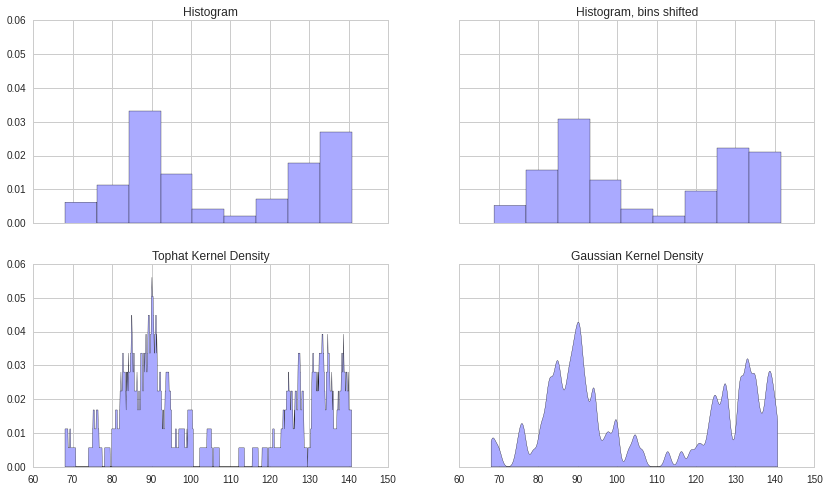

In [156]:
bottoms = [b[0] for b in bottoms]
X_bot = asset[bottoms][:,np.newaxis]
bottom_kde = fit_KDE(X_bot)

For tops:

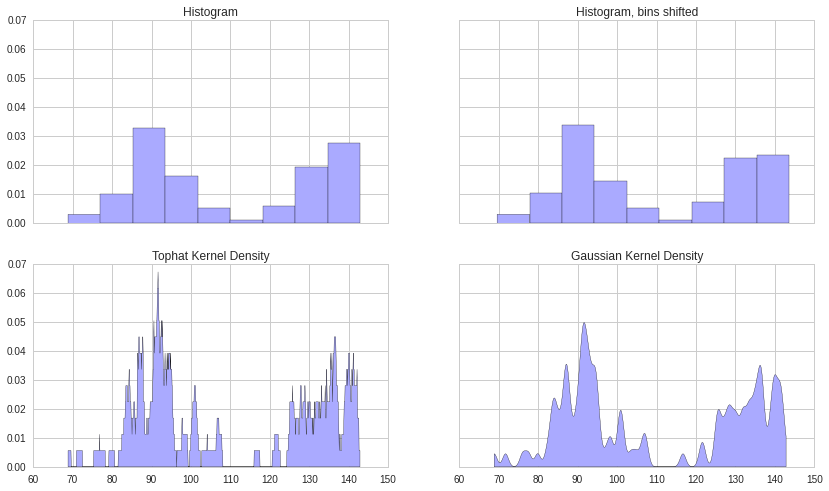

In [157]:
tops = [t[0] for t in tops]
X_top = asset[tops][:,np.newaxis]
top_kde = fit_KDE(X_top)

How do we use these distributions? One way to think about them is if the stock price is right above an area of support with a lot of mass, then we should buy. If right below and area of resistance, then we should sell. So, a straightforward way of generating the signal to buy or sell is to subtract the density function of the tops distribution from that of the bottoms distribution. Where the resulting curve is positive, the buyers outnumber the sellers and vice versa when the curve is negative. This is illustrated below.

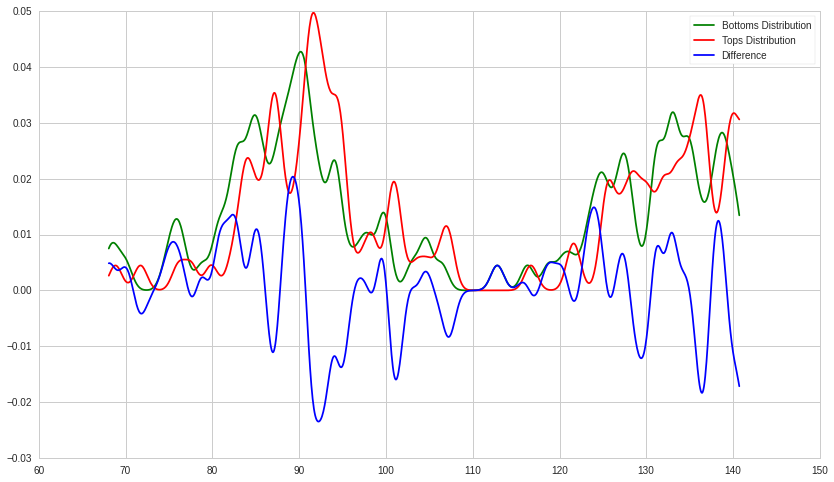

In [162]:
tmp_max = asset[bottoms].max()
tmp_min = asset[bottoms].min()
points = 1000
bottom_dist = np.exp(bottom_kde.score_samples(np.linspace(tmp_min, tmp_max, points)[:,np.newaxis]))
top_dist = np.exp(top_kde.score_samples(np.linspace(tmp_min, tmp_max, points)[:,np.newaxis]))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(tmp_min, tmp_max, points),bottom_dist,'g')
ax.plot(np.linspace(tmp_min, tmp_max, points),top_dist,'r')
ax.plot(np.linspace(tmp_min, tmp_max, points),bottom_dist-top_dist,'b')
_ = ax.legend(['Bottoms Distribution', 'Tops Distribution', 'Difference'])

How do we interpret this graph? Looking at the blue line, at a share price of 90, we see a peak, so we expect support to be at 90. On the other hand, there is a trough at 92 where we think there is a resistance level. Thus if the stock price is at 90, an algorithm might decide to buy, and if the price reaches 92, the algorithm might sell.

## Putting the Signal into Practice

A tricky part about putting this algorithm is determining the threshold at which to buy or sell. We don't want to overtrade based on noise with every oscillation of the signal, and at the same time, we want to do more than just buy and hold. Imagine a sequence of prices and at each price we'll have a "score" based on the generated distributions. I've cheated and looked at the generated scores on market data and they exhibit rather "spiky" behavior. The problem with simply buying when the score reaches a certian threshold is each stock behaves differently and has potentially different long running score averages. We need a way to keep track of a moving average and detect "spikes".


## In Progress: Peak Detection

In [172]:
p = [1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,
     1,1,1.1,0.9,1,1.1,1,1,0.9,1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,
     1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,2.6,4,3,3.2,2,1,1,0.8,
     4,4,2,2.5,1,1,1]

In [169]:
from math import sqrt
from collections import deque
from __future__ import division
import numpy as np

class RollingStatistic(object):

    ready = False
    peaking = False
    
    def __init__(self, window_size, peak_diff=1, initial_data=[]):
        self.N = window_size
        self.peak_diff = peak_diff
        self.data = deque(initial_data[-window_size:])
        if len(initial_data) >= window_size:
            start(data)

    def start(self, data):
        self.average = sum(data)/self.N
        self.variance = np.var(data)
        self.stddev = sqrt(self.variance)
        self.ready = True
        #print 'Initialized? {0}'.format(self.is_initialized)
        
        #for peak finding
        self.fake_average = self.average
        self.fake_stddev = self.stddev
        self.fake_var = self.variance

    def update(self, new):
        self.data.append(new)
        if len(self.data) < self.N:
            return self
        elif len(self.data) == self.N: # calc avg and var for the first time
            self.start(self.data)
        else:
            old = self.data.popleft()
            oldavg = self.average
            newavg = oldavg + (new - old)/self.N
            oldstddev = self.stddev
            
            self.variance = self.variance + (new-old)*(new-newavg+old-oldavg)/(self.N-1)
            self.stddev = sqrt(self.variance)           
            self.average = newavg
            
            old_fakeavg = self.fake_average
            if new < (old_fakeavg + self.peak_diff*self.fake_stddev):
                new_fakeavg = old_fakeavg + (new - old)/self.N
                self.fake_average = new_fakeavg
                self.fake_var = self.fake_var + (new-old)*(new-new_fakeavg+old-old_fakeavg)/(self.N-1)
                self.fake_stddev = sqrt(self.fake_var)
                self.peaking = False
            else:
                self.peaking = True
        return self
    
    def clear(self):
        self.data = deque()
        self.peaking = False
        self.ready = False

        #print self.data
        #print 'Avg = {self.average}, Var = {self.variance}, Std = {self.stddev}'.format(self=self)

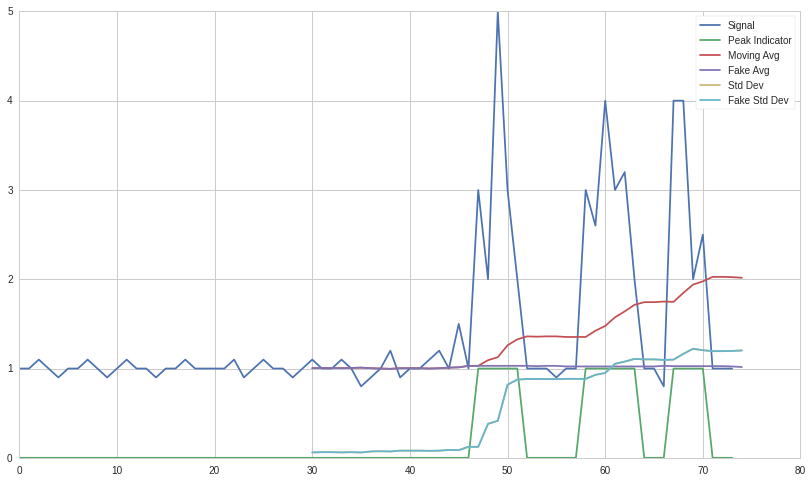

In [171]:
plt.plot(p)
window_size = 30
stddev_diff = 6
r = RollingStatistic(window_size,stddev_diff)
signal_detect = [r.update(i).peaking for i in p]
r.clear()
moving_avg = [r.average for i in p if r.update(i).ready]
r.clear()
fake_avg = [r.fake_average for i in p if r.update(i).ready]
r.clear()
stddev = [r.stddev for i in p if r.update(i).ready]
r.clear()
fake_stddev = [r.stddev for i in p if r.update(i).ready]
x_range = range(window_size,len(signal_detect)+1)
#print len(x_range)
#print len(moving_avg)
plt.plot(signal_detect)
plt.plot(x_range,moving_avg)
plt.plot(x_range,fake_avg)
plt.plot(x_range,stddev)
plt.plot(x_range,fake_stddev)
_ = plt.legend(['Signal', 'Peak Indicator', 'Moving Avg', 'Fake Avg', 'Std Dev', 'Fake Std Dev'])

In [173]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [166]:
from __future__ import division

def getKDE(prices, indices):
    X = prices[indices][:,np.newaxis]    
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
    return kde

def getScoreDist(price_history):
    bottom_indices, bottoms, _ = zip(*getBottoms(price_history))
    top_indices, tops, _ = zip(*getTops(price_history))
    
    tmp_max = max(list(tops))
    tmp_min = min(list(bottoms))
    points = 1000
    
    bottom_kde = getKDE(price_history, list(bottom_indices))
    top_kde = getKDE(price_history, list(top_indices))
    
    bottom_dist = np.exp(bottom_kde.score_samples(np.linspace(tmp_min, tmp_max, points)[:,np.newaxis]))
    top_dist = np.exp(top_kde.score_samples(np.linspace(tmp_min, tmp_max, points)[:,np.newaxis]))
    score_dist = bottom_dist-top_dist
    return (score_dist, tmp_min, tmp_max)

def getScoreIdx(curr_price, tmp_min, tmp_max, num_points):
    tmp_idx = int((curr_price-tmp_min)/(tmp_max-tmp_min)*(num_points-1))
    if tmp_idx >= num_points:
        tmp_idx = num_points-1
    if tmp_idx < 0:
        tmp_idx = 0
    return tmp_idx

(score_dist, tmp_min, tmp_max) = getScoreDist(asset)
idx = getScoreIdx(asset[0], tmp_min, tmp_max, 1000)
score_dist[idx]

0.0048646088858520734

In [167]:
idx, bottoms, _ = list(zip(*getBottoms(asset)))
list(idx)
list(bottoms)[-9:]

[135.03999999999999,
 135.00999999999999,
 133.12,
 132.72,
 135.36000000000001,
 132.97999999999999,
 131.02000000000001,
 140.00999999999999,
 138.81]